## [Occupancy Detection](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+):Data is collected using sensory feed from various devices to detect whether a room is occupied or not.Features include:
- **Date**
- **Temperature**
- **Humidity**
- **Light**
- **CO2**
- **Humidity Ratio**

# ML Pipeline 

- **Step 1**:-Import necessary packages
- **Step 2**:-Import dataset and run exploratory analysis to get insight about the kind of data we're dealing with.
- **Step 3 [Data preprocessing](https://hackernoon.com/what-steps-should-one-take-while-doing-data-preprocessing-502c993e1caa)** by partitioning it into train and test set,and performing necessary imputations,one hot encoding for categorical variables and standardization.Type of preprocessing will greatly depend on type of dataset in hand.
- **Step 4 [Model training](https://www.quora.com/How-does-a-machine-learning-model-training-work)**: Fitting any 3 model of choice to the training data.A little bit of knowledge about the algorithms will always help.
- **Step 5 [Model evaluation](https://towardsdatascience.com/model-evaluation-techniques-for-classification-models-eac30092c38b)**:Predicting the test-set labels and computing accuracy.
- **Step 6(Optional)**:Plot decision boundary.

In [3]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from IPython.display import Markdown, display
import seaborn as sns
# from keras.utils.vis_utils import plot_model


# Importing required packages:

### Note:-Download all the dependencies and packages which are not available  prior to importing the packages below.

- **sklearn** : Most important machine learning library containing most of the implemented algorithms,you just have call for help.
- **matplotlib,seaborn**: Visualization library useful for making plots.As seeing is believing.
- **keras**: Deep Learning framework based on tensorflow.You can always rely on keras for doing the hard work of implementing deep models.

- **pandas**: If you want to work with data,manipulate data, then pandas is your ally.
- **numpy**: Provides plethora of functions and tools for mathematical operations on array.
- **IPython.display**: Just used this for some printing in a markdown format.It's not necessary.




# Reading dataset and analyzing linear-relationship using correlation matrix

- **Reading Dataset**:First,we read the training and test datasets,and drop the 'date' feature,because intuitively it isn't going to give much insight about the occupancy.A typical example would be, on weekdays after the office hours,the office shuts down but date will be biased towards weekdays.

- [**Correlation analysis**]('http://learntech.uwe.ac.uk/da/default.aspx?pageid=1442')-We use the Karl-Pearson's Correlation(given by $ \rho=\frac{\text{cov}(X,Y)}{{\sigma_x}{\sigma_y}} \text{where } (0\leq \rho \leq 1)$) to calculate linear relationship between features and labels.Based on this matrix we can drop features which are correlated with each other ,and thus making our dataset free from repetitive information.



In [103]:
display(Markdown('# Correlation Matrix'))
train=pd.read_csv('datatraining.txt').drop(['date'],axis=1)
test1=pd.read_csv('datatest.txt').drop(['date'],axis=1)
test2=pd.read_csv('datatest2.txt').drop(['date'],axis=1)
train.corr(method='pearson').style.background_gradient(cmap='coolwarm')



# Correlation Matrix

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
Temperature,1,-0.141759,0.649942,0.559894,0.151762,0.53822
Humidity,-0.141759,1,0.0378279,0.439023,0.955198,0.132964
Light,0.649942,0.0378279,1,0.664022,0.23042,0.907352
CO2,0.559894,0.439023,0.664022,1,0.626556,0.712235
HumidityRatio,0.151762,0.955198,0.23042,0.626556,1,0.300282
Occupancy,0.53822,0.132964,0.907352,0.712235,0.300282,1


# Identification and treatment of outliers using box plots
    
 - [**Outlier**](https://www.analyticsvidhya.com/blog/2016/01/guide-data-exploration/)- Simply put,data which doesn't follow regular trend.In a box plot any point below the **1st Quartile** and above **3rd Quartile** is considered as a possilbe outlier.
   
- **Outlier Detection**:In this segment we plot univariate [**boxplots**](https://www.whatissixsigma.net/box-plot-diagram-to-identify-outliers/) to identify outliers and as the name suggests they are out**liars** and they heavily mislead our algorithms,so we need to get rid of them.(Note:- Sometimes outliers give necessary insights but in this problem it's least likely to behave like that)

- **Outlier Treatment**: We use capping technique **(replacing outliers with $Q3+1.5\times IQR $)** here to deal with outliers here,as I don't believe deletion of rows does any good,as we lose a lot of information about other features of that particular training example.

# Before Treatment

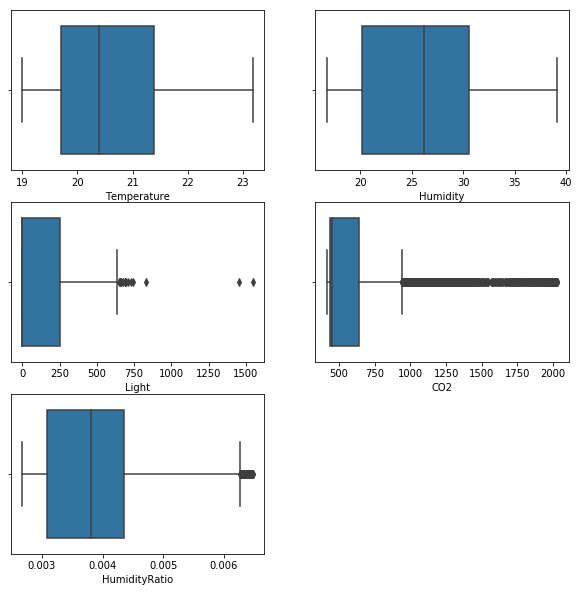

In [104]:
#Before Treatment
x_train=train.iloc[:,0:-1]
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
row,column=0,0
display(Markdown('# Before Treatment'))
for cols in x_train.columns:
    sns.boxplot(x_train[cols],ax=ax[row,column])
    column+=1
    if(column==2):
        row+=1
        column=0

fig.delaxes(ax[2,1])

# After Treatment

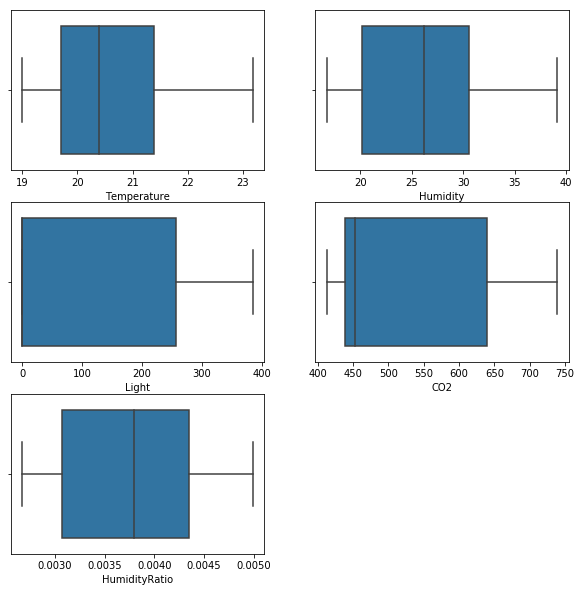

In [105]:

display(Markdown('# After Treatment'))
for  cols in ['Light','CO2','HumidityRatio']:
    Q3=x_train[cols].quantile(0.75)
    Q1=x_train[cols].quantile(0.25)
    IQR=Q3-Q1
    x_train[cols]=np.where(x_train[cols]> (Q1 + 1.5*IQR),Q1 + 1.5*IQR,x_train[cols])


#Plotting after outlier treatment
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
column=0
row=0
for cols in x_train.columns:
    sns.boxplot(x_train[cols],ax=ax[row,column])
    column+=1
    if(column==2):
        row+=1
        column=0

fig.delaxes(ax[2,1])



# Data preprocessing 

1. We can drop either of humidity or humidity-ratio as they provide us with almost same information,we can verify their correlation by peeking at the correlation matrix.
<br>
2. We partion the training,test1 & test2 datasets into its feature set and label set,as we'll be using the feature set to predict corresponding labels.
<br>
3. [**Standardizing**](http://www.dataminingblog.com/standardization-vs-normalization/) the feature set is also important, because by doing so we can bring everything down to the same scale and thus making comparison easier.Here we are converting feature distribution into Gaussian-Normal Distribution by applying <br>
($Z_{i}$ =$\frac{X_{i}- \mu}{\sigma}\text{where }(Z_{i}\text{is the transformed } X_{i},X_{i}\text{is the }i^{th} feature \in \text{Feature_set})$)

In [106]:

sc=StandardScaler()

#Partitioning into features and labels 

#train_set
train=train.drop(['Humidity'],axis=1)
x_train=train.iloc[:,0:-1]
x_train=sc.fit_transform(x_train)
train_label=train.iloc[:,-1]

#test set1
test1=test1.drop(['Humidity'],axis=1)
x_test1=test1.iloc[:,0:-1]
x_test1=sc.transform(x_test1)
# x_test1_visualize=x_test1[:,[0,2]]
test1_label=test1.iloc[:,-1]

#test set2
test2=test2.drop(['Humidity'],axis=1)
x_test2=test2.iloc[:,0:-1]
x_test2=sc.transform(x_test2)
# x_test2_visualize=x_test2[:,[0,2]]
test2_label=test2.iloc[:,-1]




# Training Phase using:

### (Note:- We didn't go for naive bayes as input features are highly correlated or dependent which violates the condition of assumed independence of [Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html))
1. Linear [**SVM**](https://scikit-learn.org/stable/modules/svm.html) classifier - A linear model is chosen as it can be observed from the coorelation matrix that outcome is highly coorelated(linearly) with the input features.This model aims to maximize the distance between it's support vectors and make the best possible decision boundary seperating the classes.

2. [**RandomForestClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html):-It's an Ensemble **(call it assemble,if that sounds easier)** algorithm **(Alogrithms which combines one or more alogrithms of same or different kind to classify objects)**.Random Forest creates a set of decision trees from subset of input features and then aggregates votes from different trees to make a decision of the final class.

3. [**Deep Neural Nets**](https://www.datacamp.com/community/tutorials/deep-learning-python):Deep Neural nets always do wonders,it's just about tinkering with the number of layers,neurons,activations and results may seem magical.Inside deep layers it's capable of computing complex functions which best predicts the output.It still remains a well sought mystery to us about what happens inside those hidden layers.**(Note:- It's also susceptible to [overfitting](https://medium.com/greyatom/what-is-underfitting-and-overfitting-in-machine-learning-and-how-to-deal-with-it-6803a989c76) the training set.**)
    


In [147]:
#training
models={'SVM':None,'RFC':None,'DNN':None}

#Using SVM classifier
clf=svm.SVC(kernel='linear',gamma='auto',C=1)
clf.fit(x_train,train_label)
models['SVM']=clf

#Using Gaussian Naive-Bayes
rnd = RandomForestClassifier(n_estimators=200,max_depth=2,random_state=0)
rnd.fit(x_train, train_label)
models['RFC']=rnd

#Using Deep Neural Nets a.k.a Multilayer-Perceptron
classifier=Sequential()

initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=0)

op=Adam(lr=0.001)
classifier.add(Dense(units=4,kernel_initializer=initializer,activation='relu',input_dim=4))

classifier.add(Dense(units=3,kernel_initializer=initializer,activation='relu'))

classifier.add(Dense(units=2,kernel_initializer=initializer,activation='relu'))

classifier.add(Dense(units=1,kernel_initializer=initializer,activation='sigmoid'))

classifier.compile(optimizer=op,loss='binary_crossentropy',metrics=['accuracy'])

history=classifier.fit(x_train,train_label,batch_size=40,epochs=10)
models['DNN']=classifier



Epoch 1/10
8143/8143 [==============================] - 4s 462us/step - loss: 0.6463 - acc: 0.7937
Epoch 2/10
8143/8143 [==============================] - 1s 108us/step - loss: 0.3427 - acc: 0.9638
Epoch 3/10
8143/8143 [==============================] - 1s 105us/step - loss: 0.1133 - acc: 0.9783
Epoch 4/10
8143/8143 [==============================] - 1s 112us/step - loss: 0.0684 - acc: 0.9875
Epoch 5/10
8143/8143 [==============================] - 1s 109us/step - loss: 0.0573 - acc: 0.9882
Epoch 6/10
8143/8143 [==============================] - 1s 108us/step - loss: 0.0535 - acc: 0.9883
Epoch 7/10
8143/8143 [==============================] - 1s 113us/step - loss: 0.0518 - acc: 0.9883
Epoch 8/10
8143/8143 [==============================] - 1s 116us/step - loss: 0.0506 - acc: 0.9882
Epoch 9/10
8143/8143 [==============================] - 1s 122us/step - loss: 0.0498 - acc: 0.9882
Epoch 10/10
8143/8143 [==============================] - 1s 111us/step - loss: 0.0493 - acc: 0.9883


# Cross-Validation

- Visualization always aids us in making important decisions about data.Cross-validation plots upholds this notion.By looking at the cross validation plots we can figure out appropriate number of epochs(No. of epochs at which accuracy or loss of both training and validation set saturates).Helps us cut off unecessary overhead of additional redundant iterations.

- For this problem we can easily see from the plots below that the appropriate no. of epochs is at about 10.

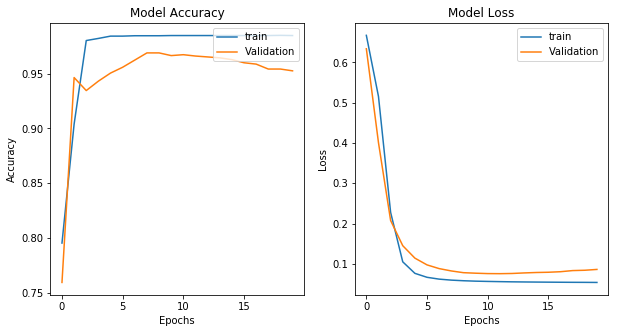

In [127]:
ax,fig=plt.subplots(1,2,figsize=(10,5))
ax=fig.flatten()
ax[0].plot(history.history['acc'])
ax[0].plot(history.history['val_acc'])
ax[0].legend(['train', 'Validation'], loc='upper right')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].legend(['train', 'Validation'], loc='upper right')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
plt.show()



In [148]:
display(Markdown('# Deep Neural Net Model Summary'))
classifier.summary()
# plot_model(classifier, to_file='dnn_plot.png', show_shapes=True, show_layer_names=True)

# Deep Neural Net Model Summary

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_173 (Dense)            (None, 4)                 20        
_________________________________________________________________
dense_174 (Dense)            (None, 3)                 15        
_________________________________________________________________
dense_175 (Dense)            (None, 2)                 8         
_________________________________________________________________
dense_176 (Dense)            (None, 1)                 3         
Total params: 46
Trainable params: 46
Non-trainable params: 0
_________________________________________________________________


# Deep Neural Net Model Visualization

<img src="dnn_plot.png">

In [129]:
display(Markdown('# Datatrain'))
for i in models.keys():
    predictions=models[i].predict(x_train)>0.5
    Accuracy=round(accuracy_score(predictions,train_label)*100,2)
    display(Markdown('### '+i+' '+'(Accuracy='+str(Accuracy)+'%)'))
    display(Markdown('### Confusion Matrix'))
    print(confusion_matrix(predictions,train_label))

display(Markdown('# -----------------------------------------------------------------'))

# Datatrain

### SVM (Accuracy=98.6%)

### Confusion Matrix

[[6321   21]
 [  93 1708]]


### RFC (Accuracy=98.81%)

### Confusion Matrix

[[6324    7]
 [  90 1722]]


### DNN (Accuracy=98.82%)

### Confusion Matrix

[[6324    6]
 [  90 1723]]


# -----------------------------------------------------------------

# Testing Phase using: dataset1 & 2
   [Confusion Matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)- It's a method of visualizing how good or bad your predictions are in a matrix format. It's a ($2\times2$ matrix where each value represents one of $\{\text{predicted true,predicted false}\}\times \{\text{actual true,actual false}\}$, $2^{2}=4$ outcomes.
- **Datatest_1**:Confusion Matrix for **(SVM,Gaussian Naive-Bayes,Deep Neural Nets)**.
- **Datatest 2**:Printing the confusion matrix and accuracy of all the models i.e **(SVM,Gaussian Naive-Bayes,Deep Neural Nets) for datatest2.**

In [130]:
Markdown('# Datatest_1')
for i in models.keys():
    predictions=models[i].predict(x_test1)>0.5
    Accuracy=round(accuracy_score(predictions,test1_label)*100,2)
    display(Markdown('### '+i+' '+'(Accuracy='+str(Accuracy)+'%)'))
    display(Markdown('### Confusion Matrix'))
    print(confusion_matrix(predictions,test1_label))

display(Markdown('# -----------------------------------------------------------------'))

display(Markdown('# Datatest_2'))
for i in models.keys():
    predictions=models[i].predict(x_test2)>0.5
    Accuracy=round(accuracy_score(predictions,test2_label)*100,2)
    display(Markdown('### '+i+' '+'(Accuracy='+str(Accuracy)+'%)'))
    display(Markdown('### Confusion Matrix'))
    print(confusion_matrix(predictions,test2_label),"\n")

### SVM (Accuracy=97.86%)

### Confusion Matrix

[[1639    3]
 [  54  969]]


### RFC (Accuracy=97.86%)

### Confusion Matrix

[[1639    3]
 [  54  969]]


### DNN (Accuracy=97.86%)

### Confusion Matrix

[[1638    2]
 [  55  970]]


# -----------------------------------------------------------------

# Datatest_2

### SVM (Accuracy=99.25%)

### Confusion Matrix

[[7644   14]
 [  59 2035]] 



### RFC (Accuracy=99.31%)

### Confusion Matrix

[[7648   12]
 [  55 2037]] 



### DNN (Accuracy=99.06%)

### Confusion Matrix

[[7625   14]
 [  78 2035]] 



# Visualization of decision boundary using 2 variables

- Everything beneath this point is involved in plotting decision boundary on training set seperating 2 classes,to give a visual feel of how classification works.

- We've used [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to extract 2 features **(Note:- We aren't simply selecting a subset of features,we're rather applying this algorithm to transform our existing feature space into a 2d space.)** along which the variance is maximum.This isn't the only way for dimensionality reduction but it suits our purpose very well in this case.


In [131]:
#Helper functions to plot decision boundary

def make_meshgrid(x, y, h=.02):
  
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
 
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    


In [132]:
#Dimensionality reduction
x_train_visualize=PCA(n_components=2).fit_transform(x_train)

In [142]:
#training
models1={'SVM':None,'RFC':None,'DNN':None}

#Using SVM classifier
clf=svm.SVC(kernel='linear', C=1,gamma='auto')
clf.fit(x_train_visualize,train_label)
models1['SVM']=clf

#Using RandomForest

rnd = RandomForestClassifier(n_estimators=100,max_depth=2,random_state=0)
rnd.fit(x_train_visualize, train_label)
models1['RFC']=rnd

#Using Deep Neural Nets a.k.a Multilayer-Perceptron
classifier1=Sequential()

initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

op=Adam(lr=0.001)
classifier1.add(Dense(units=4,kernel_initializer=initializer,activation='relu',input_dim=2))

classifier1.add(Dense(units=3,kernel_initializer=initializer,activation='relu'))

classifier1.add(Dense(units=2,kernel_initializer=initializer,activation='relu'))

classifier1.add(Dense(units=1,kernel_initializer=initializer,activation='sigmoid'))

classifier1.compile(optimizer=op,loss='binary_crossentropy',metrics=['accuracy'])

classifier1.fit(x_train_visualize,train_label,batch_size=40,epochs=10)
models1['DNN']=classifier1

Epoch 1/10
8143/8143 [==============================] - 4s 463us/step - loss: 0.6465 - acc: 0.7895
Epoch 2/10
8143/8143 [==============================] - 1s 108us/step - loss: 0.3729 - acc: 0.9423
Epoch 3/10
8143/8143 [==============================] - 1s 107us/step - loss: 0.1591 - acc: 0.9509
Epoch 4/10
8143/8143 [==============================] - 1s 107us/step - loss: 0.1251 - acc: 0.9543
Epoch 5/10
8143/8143 [==============================] - 1s 107us/step - loss: 0.1188 - acc: 0.9568
Epoch 6/10
8143/8143 [==============================] - 1s 106us/step - loss: 0.1163 - acc: 0.9605
Epoch 7/10
8143/8143 [==============================] - 1s 117us/step - loss: 0.1148 - acc: 0.9587
Epoch 8/10
8143/8143 [==============================] - 1s 111us/step - loss: 0.1136 - acc: 0.9590
Epoch 9/10
8143/8143 [==============================] - 1s 115us/step - loss: 0.1127 - acc: 0.9619
Epoch 10/10
8143/8143 [==============================] - 1s 105us/step - loss: 0.1117 - acc: 0.9608


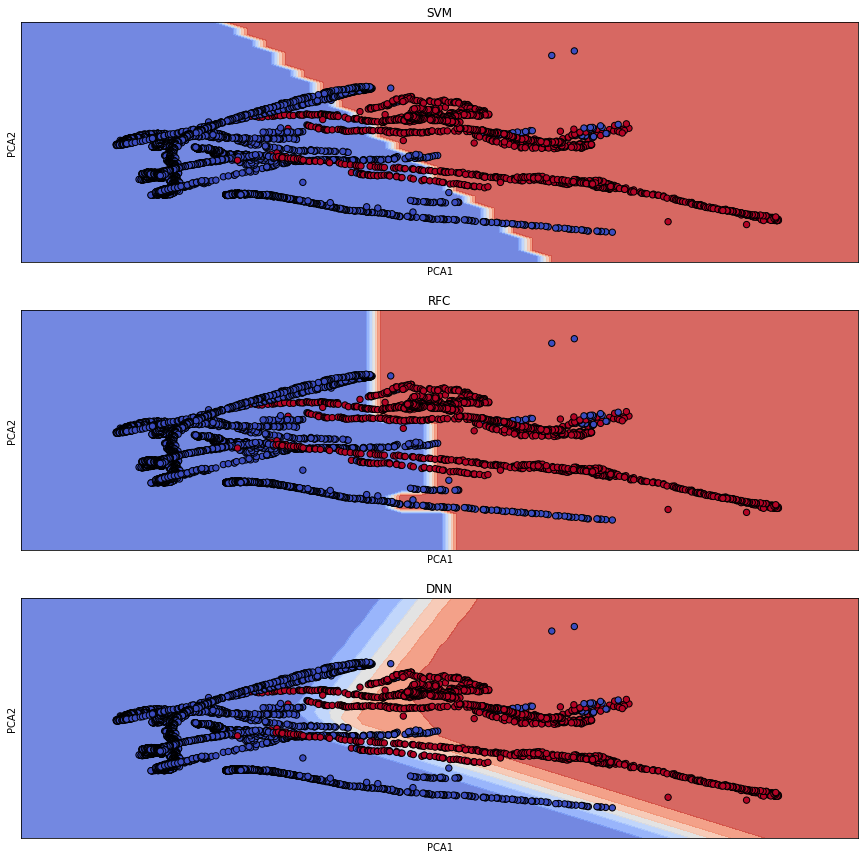

In [143]:
# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(3,1,figsize=(15,15))
# plt.subplots_adjust(wspace=1.4, hspace=1.4)
x0,x1=x_train_visualize[:,0],x_train_visualize[:,1]
xx,yy=make_meshgrid(x0,x1,0.2)

for clf,ax in zip(models1,sub.flatten()):
    
    plot_contours(ax,models1[clf],xx,yy,cmap=plt.cm.coolwarm,alpha=0.8)
    ax.scatter(x0, x1, c=train_label, cmap=plt.cm.coolwarm, s=40, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(clf)